In [420]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
from load_kat_data import *
import get_WS
import trace_mode

In [421]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [422]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(pds)
basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(2))
basekat.parseCommands("""
qnoised NSR_shot_rad 1 $fs nOMC_AROC_trans
qd qdA 0 0 nOMC_AROC_trans
qd qdP 0 90 nOMC_AROC_trans
sd sd00 0 0 0 nOMC_AROC_trans
sd sd01 0 0 1 nOMC_AROC_trans
sd sd02 0 0 2 nOMC_AROC_trans


qnoised PDquantumnoise 1 $fs nOMC_AROC_trans

sd sd00OFI 0 0 0 nlensFC1a
sd sd01OFI 0 0 1 nlensFC1a
sd sd02OFI 0 0 2 nlensFC1a


ad OMCoutTEM00 0 0 0 nOMC_AROC_trans
ad OMCoutTEM01 0 1 0 nOMC_AROC_trans
ad OMCoutTEM02 0 2 0 nOMC_AROC_trans

pd1 signal $fs nOMC_AROC_trans
""")
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

#kat.IMFC.Rc.value = -16.0
kat.EMFC.Rcx.value = 16.0
kat.EMFC.Rcy.value = 16.0

out_perfect_mm_dFC = kat.run() 

SR3_Rc_orig = kat.SR3.Rc.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nlensFC1a` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nlensFC1a` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02OFI 0 0 2 nlensFC1a` into pykat object not implemented yet, added as extra line.


In [423]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [424]:
###
###Extract the eigenmode of SRC with offsets in SR3

max_offset_SR3 = .01834

#Add Commands
basekat1 = pykat.finesse.kat() 
basekat1.loadKatFile(katfile)
basekat1.parseCommands(commands)
basekat1.parseCommands(amplitude_detectors)
basekat1.parseCommands(pds)
basekat1.parseCommands(add_squeezing)
basekat1.undumpNodes()
basekat1.parseCommands("maxtem "+str(2))
basekat1.parseCommands("qnoised NSR_shot 1 $fs nOMC_AROC_trans")
kat1=basekat1.deepcopy() 
kat1.verbose = False

# Change the SR3HR_Roc
SR3_Rc_new = SR3_Rc_orig + max_offset_SR3
kat1.SR3.Rcx.value = SR3_Rc_new
kat1.SR3.Rcy.value = SR3_Rc_new

#Run and extract the q's at the OFI and SRMHR
out_new_SR3_roc = kat1.run()
   
#### Extract the mode at the SRMAR w.r.t the ARM
for cav in kat1.getAll(pykat.commands.cavity):
    cav.enabled = False
kat1.cavXARM.enabled = True
kat1.cavYARM.enabled = True
get_SRM_q_wrt_cavARM = kat1.run(getTraceData=True)
    
#### Extract the mode at the OFI w.r.t the OMC
for cav in kat1.getAll(pykat.commands.cavity):
    cav.enabled = False
kat1.cavOMC.enabled = True
get_OFI_qx_wrt_OMC = kat1.run(getTraceData=True)

q_refin_x = get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q
q_refin_y = get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q

q_refout_x = -np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q)
q_refout_y = -np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q)

In [425]:
### Get the mode-matching parameters for FC to SRC

#### Extract the mode at the FC w.r.t the FC
for cav in kat1.getAll(pykat.commands.cavity):
    cav.enabled = False
kat1.cavFC.enabled = True
kat1.lensFC1.f.value = 'inf'
kat1.lensFC2.f.value = 'inf'
get_FC_q = kat1.run(getTraceData=True)

#### Extract the mode at the FC w.r.t the SRC
for cav in kat1.getAll(pykat.commands.cavity):
    cav.enabled = False
#kat1.cavSRX.enabled = True
#kat1.cavSRY.enabled = True
kat1.cavXARM.enabled = True
kat1.cavYARM.enabled = True
#kat1.lensFC1.f.value = 'inf'
#kat1.lensFC2.f.value = 'inf'
get_FC_q_wrt_SRC = kat1.run(getTraceData=True)

In [426]:
q_refin_x_FC = get_FC_q[1][0]['nIMFC2'][0]._gauss_param__q
q_refin_y_FC = get_FC_q[1][0]['nIMFC2'][1]._gauss_param__q

q_refout_x_FC = -np.conjugate(get_FC_q_wrt_SRC[1][0]['nOFIout2'][0]._gauss_param__q)
q_refout_y_FC = -np.conjugate(get_FC_q_wrt_SRC[1][0]['nOFIout2'][1]._gauss_param__q)

In [427]:
get_SRM_q_wrt_cavARM[1][0]['nOFIout2'][0]._gauss_param__q

(-3.07838268940989+1.09691571838711j)

In [428]:
get_FC_q_wrt_SRC[1][0]['nPRBS'][0]._gauss_param__q

(1355.17097026103+225.942757840206j)

In [429]:
check_q[1][0]['nPRBS'][0]._gauss_param__q

(-1353.7773024107+229.923468163986j)

In [430]:
basekat2 = pykat.finesse.kat() 
basekat2.loadKatFile(katfile)
basekat2.parseCommands(darm_commands)
basekat2.parseCommands(amplitude_detectors)
basekat2.parseCommands(pds)
basekat2.parseCommands(add_squeezing)
basekat2.parseCommands("maxtem "+str(2))
basekat2.parseCommands("""
qnoised NSR_shot_rad 1 $fs nOMC_AROC_trans

qd qdA 0 0 nOMC_AROC_trans
qd qdP 0 90 nOMC_AROC_trans

sd sd00 0 0 0 nOMC_AROC_trans
sd sd01 0 0 1 nOMC_AROC_trans
sd sd02 0 0 2 nOMC_AROC_trans

qnoised PDquantumnoise 1 $fs nOMC_AROC_trans

sd sd00OFI 0 0 0 nIMFC1
sd sd01OFI 0 0 1 nIMFC1
sd sd02OFI 0 0 2 nIMFC1

pd1 signal $fs nOMC_AROC_trans

ad OMCoutTEM00 0 0 0 nOMC_AROC_trans
ad OMCoutTEM01 0 1 0 nOMC_AROC_trans
ad OMCoutTEM02 0 2 0 nOMC_AROC_trans
""")
basekat2.undumpNodes()

kat2=basekat2.deepcopy()
kat2.verbose = False
    
SR3_Rc = kat.SR3.Rc
dRc = max_offset_SR3
    
kat2.SR3.Rcx.value = SR3_Rc + dRc
kat2.SR3.Rcy.value = SR3_Rc + dRc


###Modematch the arms to the OMC
#
#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = q_refin_x
q2 = q_refout_x
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat2.lSRMTT1.L.value = d1
kat2.SRMTT1.f.value = f1
kat2.lSRMTT2.L.value = d2
kat2.SRMTT2.f.value = f2
kat2.lIBAin.L.value = d3

"""###Modematch the FC to the SRC
q1_FC = q_refin_x_FC 
q2_FC = q_refout_x_FC 
D_FC  = 1 # total distance from SRC to OFI
d1_FC = 0.25
d2_FC = 0.00001
d3_FC = D_FC - d1_FC - d2_FC

[f1_FC, f2_FC] = modematch(q1_FC, q2_FC, d1_FC, d2_FC, d3_FC)

kat2.llensFC_FC.L.value = d1_FC
kat2.lensFC2.f.value = f1_FC
kat2.llensFC1_lensFC2.L.value = d2_FC
kat2.lensFC1.f.value = f2_FC
kat2.lOP_lensFC.L.value = d3_FC"""

#kat2.IMFC.Rcx.value = -16.0
kat2.EMFC.Rcx.value = 16.0
kat2.EMFC.Rcy.value = 16.0

out2 = kat2.run()

freq = out2.x
darm_list = out2['NSR_with_RP']
kat2.saveScript("VarySR3_95MM_wSqz_MMTTon_maxtem4.kat")

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02OFI 0 0 2 nIMFC1` into pykat object not implemented yet, added as extra line.
Successfully Mode-Matched! >99.9% overlap
f1 is 0.0013434807517578487
f2 is -0.0012434391643174137


In [431]:
check_q = kat2.run(getTraceData=True)

In [432]:
FCx

(1354.6169445242+227.859622865522j)

In [433]:
"""#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat2,'cavSRY')

#### Turn off all the cav commands except YARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat2,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat2,'cavOMC')

#### Turn off all the cav commands except FC to extract the eigenmode at the BS
[FCx,FCy] = trace_mode.from_cav_to_BS(kat2,'cavFC')

f_overlap_SRC_to_ARM_x = pykat.beam_param.overlap(srcx,ARMx)
f_overlap_SRC_to_ARM_y = pykat.beam_param.overlap(srcy,ARMy)"""

"#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS\n[srcx,srcy] = trace_mode.from_cav_to_BS(kat2,'cavSRY')\n\n#### Turn off all the cav commands except YARM to extract the eigenmode at the BS\n[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat2,'cavXARM')\n\n#### Turn off all the cav commands except OMC to extract the eigenmode at the BS\n[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat2,'cavOMC')\n\n#### Turn off all the cav commands except FC to extract the eigenmode at the BS\n[FCx,FCy] = trace_mode.from_cav_to_BS(kat2,'cavFC')\n\nf_overlap_SRC_to_ARM_x = pykat.beam_param.overlap(srcx,ARMx)\nf_overlap_SRC_to_ARM_y = pykat.beam_param.overlap(srcy,ARMy)"

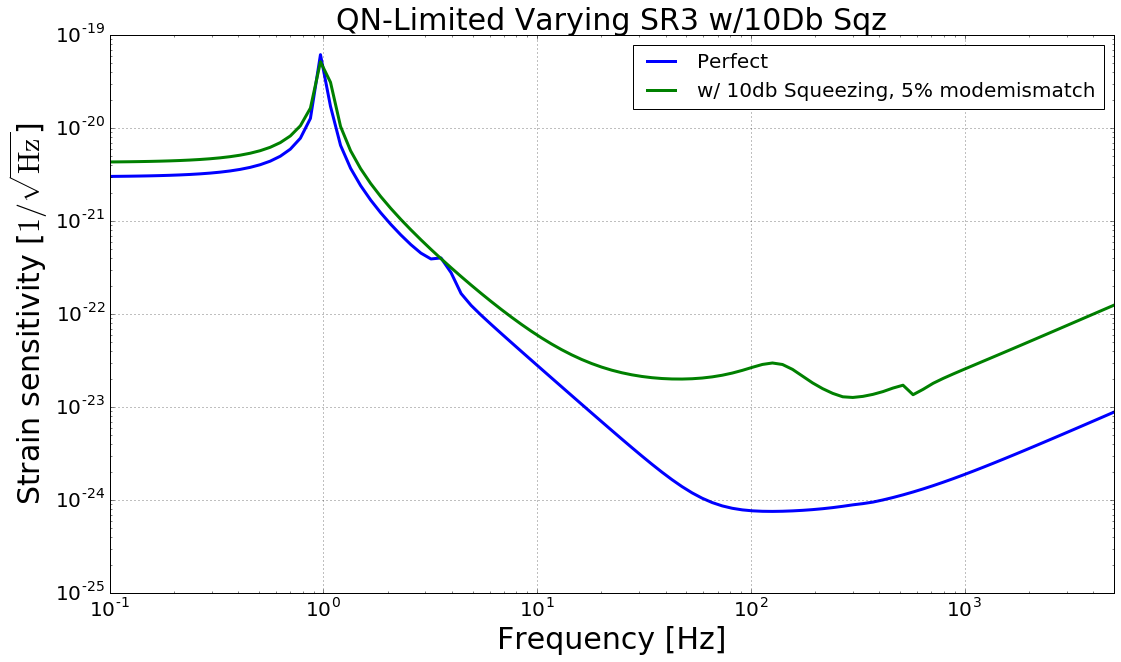

In [434]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(111)
pl.loglog(freq, np.real(out_perfect_mm['NSR_with_RP']),linewidth=3, label='Perfect')
pl.loglog(freq, np.real(darm_list),linewidth=3, label='w/ 10db Squeezing, 5% modemismatch')


pl.title("QN-Limited Varying SR3 w/10Db Sqz",fontsize=30)
pl.xlim(freq.min(),freq.max())
#pl.ylim(7e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)


pl.show()


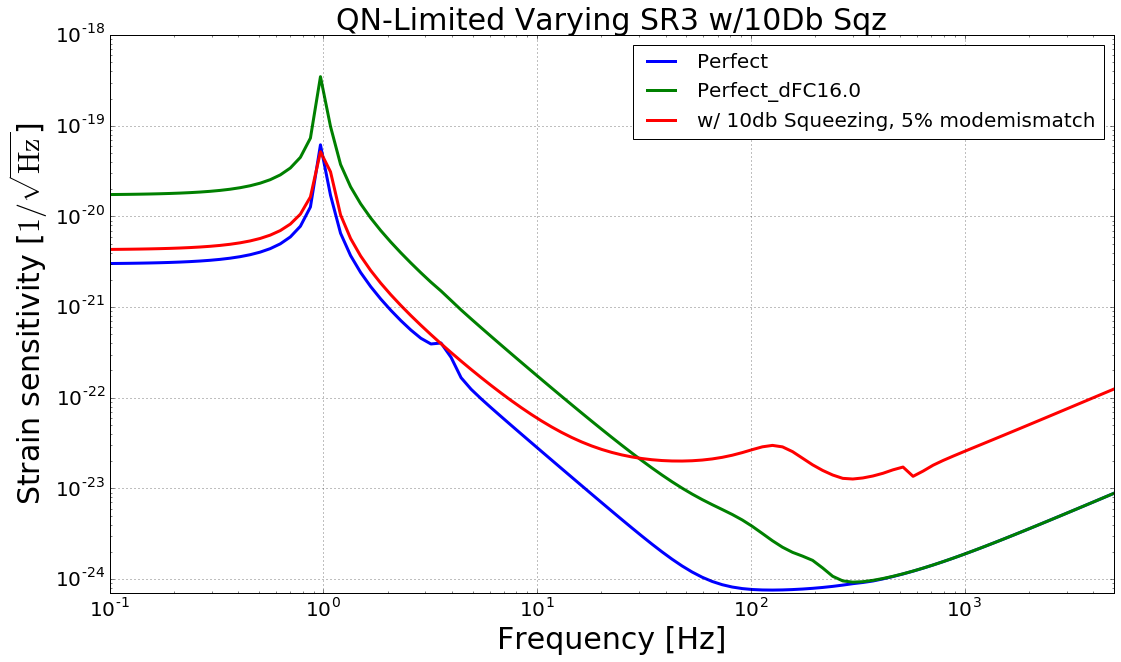

In [439]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(111)
pl.loglog(freq, np.real(out_perfect_mm['NSR_with_RP']),linewidth=3, label='Perfect')
pl.loglog(freq, np.real(out_perfect_mm_dFC['NSR_with_RP']),
          linewidth=3, label='Perfect_dFC'+str(kat2.EMFC.Rcx.value))
pl.loglog(freq, np.real(darm_list),linewidth=3, label='w/ 10db Squeezing, 5% modemismatch')


pl.title("QN-Limited Varying SR3 w/10Db Sqz",fontsize=30)
pl.xlim(freq.min(),freq.max())
pl.ylim(7e-25,1e-18)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)


pl.show()


In [436]:
kat2.EMFC.Rc